<a href="https://colab.research.google.com/github/chidao87/Chi-/blob/main/AIMarketing_Ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective:** Predict customer churn, analyze retention with survival analysis, and propose strategies

**Tasks:** Explore dataset, calculate churn rate, train logistic regression, apply Kaplan-Meier analysis, visualize results

**Dataset:** https://github.com/amrahmani/Marketing/blob/main/customer_churn_data.csv

**Features**:

customerID: A unique identifier for each customer.

Gender: The customer's biological sex (Male or Female).

SeniorCitizen: Indicates if the customer is a senior citizen (1 = Yes, 0 = No).

Partner: Indicates if the customer has a partner (Yes or No).

Dependents: Indicates if the customer has dependents (Yes or No).

tenure: The number of months the customer has been with the company.

PhoneService: Indicates if the customer has phone service (Yes or No).

MultipleLines: Indicates if the customer has multiple phone lines (Yes, No, or No phone service).

InternetService: The customer's internet service provider (DSL, Fiber optic, or No internet service).

OnlineSecurity: Indicates if the customer has online security (Yes, No, or No internet service).

OnlineBackup: Indicates if the customer has online backup service (Yes, No, or No internet service).

DeviceProtection: Indicates if the customer has device protection (Yes, No, or No internet service).

TechSupport: Indicates if the customer has tech support (Yes, No, or No internet service).

StreamingTV: Indicates if the customer has streaming TV service (Yes, No, or No internet service).

StreamingMovies: Indicates if the customer has streaming movie service (Yes, No, or No internet service).

Contract: The type of contract the customer has (e.g., Month-to-month, One year, Two year).

PaperlessBilling: Indicates if the customer has paperless billing (Yes or No).

PaymentMethod: The customer's payment method.

MonthlyCharges: The amount the customer is charged monthly.

TotalCharges: The total amount the customer has been charged.

Churn: Indicates if the customer has left the service (Yes or No).

In [82]:
!pip install lifelines


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from lifelines import KaplanMeierFitter
import warnings

warnings.filterwarnings('ignore')

# Set plot style for better visualization
plt.style.use('seaborn-v0_8-darkgrid')

# Step 1: Load and Explore the Dataset
url = "https://raw.githubusercontent.com/amrahmani/Marketing/main/customer_churn_data.csv"
df = pd.read_csv(url)

# Display first 5 rows
print("Dataset Preview:")
print(df.head())

# Summarize dataset statistics
print("\nDataset Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())



Dataset Preview:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies    

In [84]:
# Step 2: Data Preprocessing
# Handle missing values in TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Convert Churn to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Encode categorical variables
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Select features
features = ['tenure', 'MonthlyCharges', 'TotalCharges'] + \
            [col for col in df.columns if col.startswith(('gender_', 'Partner_', 'Contract_'))]
X = df[features]
y = df['Churn']

# Normalize numerical features
scaler = StandardScaler()
X[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(
    X[['tenure', 'MonthlyCharges', 'TotalCharges']]
)

In [85]:
print("\nScaled Numerical Features Preview:")
print(X[['tenure', 'MonthlyCharges', 'TotalCharges']].head())


Scaled Numerical Features Preview:
     tenure  MonthlyCharges  TotalCharges
0 -1.277445       -1.160323     -0.994242
1  0.066327       -0.259629     -0.173244
2 -1.236724       -0.362660     -0.959674
3  0.514251       -0.746535     -0.194766
4 -1.236724        0.197365     -0.940470



Churn Rate: 26.54%


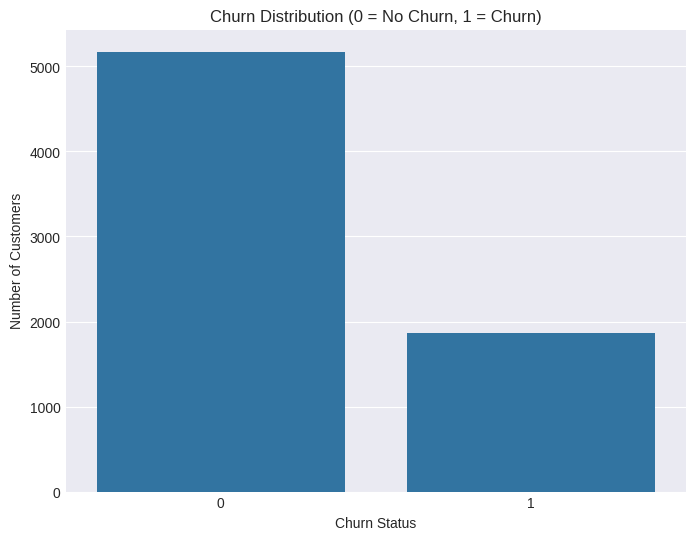

In [86]:
# Step 3: Calculate Churn Rate
churn_rate = (df['Churn'].mean() * 100)
print(f"\nChurn Rate: {churn_rate:.2f}%")

# Visualize churn distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution (0 = No Churn, 1 = Churn)')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.show()  # Display the plot


In [87]:
# Step 4: Train Logistic Regression Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predict churn probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate model
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


ROC-AUC Score: 0.8495


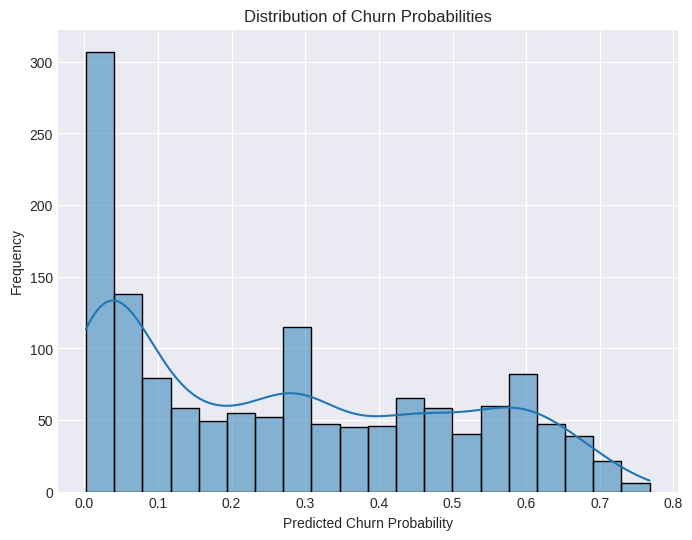

In [88]:
# Step 5: Visualize Churn Probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba, bins=20, kde=True)
plt.title('Distribution of Churn Probabilities')
plt.xlabel('Predicted Churn Probability')
plt.ylabel('Frequency')
plt.show()  # Display the plot



In [89]:
# Step 6: Analyze Logistic Regression Coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nTop 5 Features Influencing Churn:")
print(coef_df.head())
print("\nAll Coefficients:")
print(coef_df)  # Print all coefficients




Top 5 Features Influencing Churn:
             Feature  Coefficient
1     MonthlyCharges     0.736654
2       TotalCharges     0.371976
4        Partner_Yes    -0.024266
3        gender_Male    -0.035854
5  Contract_One year    -1.021769

All Coefficients:
             Feature  Coefficient
1     MonthlyCharges     0.736654
2       TotalCharges     0.371976
4        Partner_Yes    -0.024266
3        gender_Male    -0.035854
5  Contract_One year    -1.021769
0             tenure    -1.167057
6  Contract_Two year    -2.039770


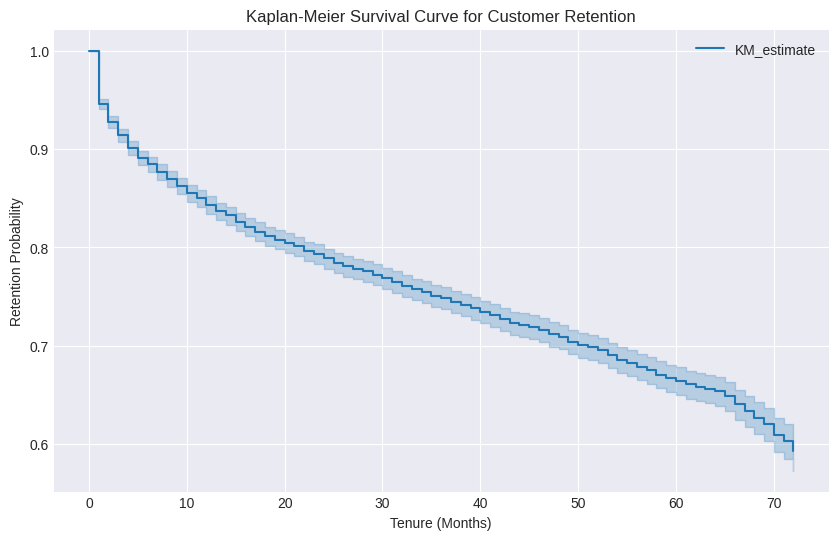

In [90]:
# Step 7: Kaplan-Meier Survival Analysis
kmf = KaplanMeierFitter()
kmf.fit(df['tenure'], event_observed=df['Churn'])

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve for Customer Retention')
plt.xlabel('Tenure (Months)')
plt.ylabel('Retention Probability')
plt.show()  # Display the plot



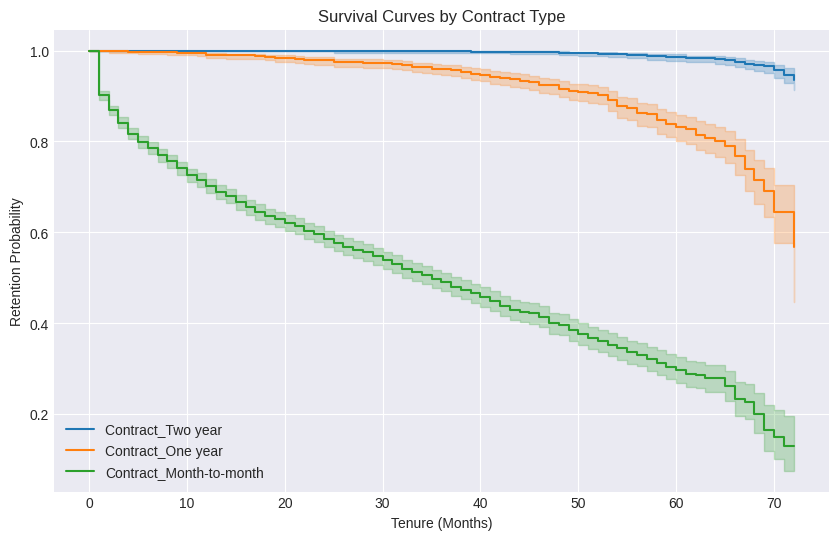

In [91]:
# Step 8: Survival Curves by Contract Type
contract_types = ['Contract_Two year', 'Contract_One year', 'Contract_Month-to-month']
plt.figure(figsize=(10, 6))

for contract in contract_types:
    if contract == 'Contract_Month-to-month':
        mask = (df['Contract_One year'] == 0) & (df['Contract_Two year'] == 0)
    else:
        mask = df[contract] == 1

    kmf_contract = KaplanMeierFitter()
    kmf_contract.fit(df[mask]['tenure'], event_observed=df[mask]['Churn'], label=contract)
    kmf_contract.plot_survival_function()

plt.title('Survival Curves by Contract Type')
plt.xlabel('Tenure (Months)')
plt.ylabel('Retention Probability')
plt.show()  # Display the plot



In [92]:
# Step 9: Print Predictions Summary
test_results = X_test.copy()
test_results['Churn_Probability'] = y_pred_proba
test_results['Actual_Churn'] = y_test

print("\nChurn Predictions Summary:")
print(test_results.describe())
print("\nFirst 10 Predictions:")
print(test_results.head(10))




Churn Predictions Summary:
            tenure  MonthlyCharges  TotalCharges  Churn_Probability  \
count  1409.000000     1409.000000   1409.000000        1409.000000   
mean     -0.000316       -0.013630     -0.013507           0.269490   
std       1.022106        1.000406      1.007022           0.223273   
min      -1.318165       -1.530904     -0.999076           0.002119   
25%      -0.992402       -0.999129     -0.851114           0.053101   
50%      -0.177995        0.167453     -0.414888           0.245311   
75%       0.962175        0.827186      0.643626           0.462573   
max       1.613701        1.794352      2.821291           0.767734   

       Actual_Churn  
count   1409.000000  
mean       0.264727  
std        0.441344  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000  

First 10 Predictions:
        tenure  MonthlyCharges  TotalCharges  gender_Male  Partner_Yes  \
185  -1.277445       -1.328164     -0

In [93]:
# Step 10: Generate and Print Report Summary
report = f"""
AI in Marketing Session 4 Hands-On Report
=======================================
Dataset: Telco Customer Churn
URL: {url}

1. Churn Rate: {churn_rate:.2f}%
   - Indicates significant retention challenges.
   - Month-to-month contracts show higher churn.

2. Logistic Regression Results:
   - ROC-AUC: {roc_auc:.4f}
   - Key drivers: Tenure (negative), MonthlyCharges (positive).
   - High-probability customers need retention focus.

3. Survival Analysis:
   - Survival curve shows steep drop in early months.
   - Two-year contracts retain customers longer than month-to-month.

Retention Strategy:
- Offer discounts to high-probability churners (probability > 0.5).
- Enroll long-tenure customers in loyalty programs.
- Survey month-to-month customers to identify pain points.

Survey Proposal:
1. How satisfied are you with our service? (1–5 scale)
2. What is the primary reason you might switch providers?
3. How likely are you to recommend us? (NPS, net promoter score) (1–5 scale)
4. Are pricing plans meeting your needs? (Yes/No)
5. What improvements would enhance your experience?

"""

print("\n--- Report Summary ---")
print(report)


--- Report Summary ---

AI in Marketing Session 4 Hands-On Report
Dataset: Telco Customer Churn
URL: https://raw.githubusercontent.com/amrahmani/Marketing/main/customer_churn_data.csv

1. Churn Rate: 26.54%
   - Indicates significant retention challenges.
   - Month-to-month contracts show higher churn.

2. Logistic Regression Results:
   - ROC-AUC: 0.8495
   - Key drivers: Tenure (negative), MonthlyCharges (positive).
   - High-probability customers need retention focus.

3. Survival Analysis:
   - Survival curve shows steep drop in early months.
   - Two-year contracts retain customers longer than month-to-month.

Retention Strategy:
- Offer discounts to high-probability churners (probability > 0.5).
- Enroll long-tenure customers in loyalty programs.
- Survey month-to-month customers to identify pain points.

Survey Proposal:
1. How satisfied are you with our service? (1–5 scale)
2. What is the primary reason you might switch providers?
3. How likely are you to recommend us? (NPS, 

**Activity:**

**Task 1:** Calculate churn rate for customers with month-to-month contracts. Plot a bar chart comparing it to the overall churn rate. Interpret the difference in 100 words.

**Task 2:** Modify the logistic regression model to include ‘SeniorCitizen’ as a feature. Report the new ROC-AUC score and coefficient. Explain its impact in 100 words.

**Task 3:** Create Kaplan-Meier survival curves for customers with and without TechSupport.

**Task 4:** Identify top 10% of customers by churn probability. Propose a retention campaign for them and justify it in 100 words using churn prediction results.

**Task 1: Calculate churn rate for customers with month-to-month contracts. Plot a bar chart comparing it to the overall churn rate. Interpret the difference in 100 words.**


Churn Rate for Month-to-Month Contracts: 42.71%


<Figure size 1000x600 with 0 Axes>

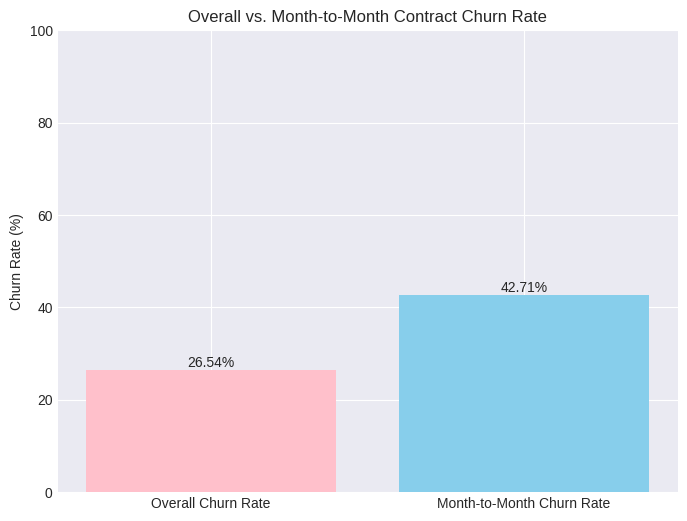


Interpretation:

The churn rate for customers with month-to-month contracts (42.71%) is significantly higher than the overall churn rate (26.54%).
This difference highlights the increased risk of churn among customers who are less committed and more likely to leave..
Month-to-month contracts offer customers more flexibility to switch providers, making them more susceptible to competitor offers or dissatisfaction with the service.
This customer segmentation should be priority targets for retention efforts such as: special loyalty rewards, personalized offers or discounts, encouragement to upgrade to longer-term contracts
A month-to-month contract might reflect customer uncertainty about the service or past dissatisfaction. These customers might have joined recently or had bad experiences. Collecting feedback and improving customer support or onboarding could help reduce churn.
Since they're already customers, there's an opportunity to upsell to more stable (and often more profitable) l

In [94]:
# Calculate churn rate for customers with month-to-month contracts

contract_types = ['Contract_Two year', 'Contract_One year', 'Contract_Month-to-month']
plt.figure(figsize=(10, 6))

for contract in contract_types:
    if contract == 'Contract_Month-to-month':
        month_to_month_mask = (df['Contract_One year'] == 0) & (df['Contract_Two year'] == 0)
    else:
        month_to_month_mask = df[contract] == 1

month_to_month_churn_rate = df[month_to_month_mask]['Churn'].mean() * 100
print(f"\nChurn Rate for Month-to-Month Contracts: {month_to_month_churn_rate:.2f}%")

# Plotting the bar chart
churn_rates = {
    'Overall Churn Rate': churn_rate,
    'Month-to-Month Churn Rate': month_to_month_churn_rate
}

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
bars = plt.bar(churn_rates.keys(), churn_rates.values(), color=['pink', 'skyblue'])
plt.ylabel('Churn Rate (%)')
plt.title('Overall vs. Month-to-Month Contract Churn Rate')
plt.ylim(0, 100)

# Add values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}%', ha='center', va='bottom')

plt.show()

#Interpretation
interpretation = """
The churn rate for customers with month-to-month contracts ({month_to_month_churn_rate:.2f}%) is significantly higher than the overall churn rate ({churn_rate:.2f}%).
This difference highlights the increased risk of churn among customers who are less committed and more likely to leave..
Month-to-month contracts offer customers more flexibility to switch providers, making them more susceptible to competitor offers or dissatisfaction with the service.
This customer segmentation should be priority targets for retention efforts such as: special loyalty rewards, personalized offers or discounts, encouragement to upgrade to longer-term contracts
A month-to-month contract might reflect customer uncertainty about the service or past dissatisfaction. These customers might have joined recently or had bad experiences. Collecting feedback and improving customer support or onboarding could help reduce churn.
Since they're already customers, there's an opportunity to upsell to more stable (and often more profitable) longer-term contracts
"""
print("\nInterpretation:")
print(interpretation.format(month_to_month_churn_rate=month_to_month_churn_rate, churn_rate=churn_rate))

**Task 2: Modify the logistic regression model to include ‘SeniorCitizen’ as a feature. Report the new ROC-AUC score and coefficient. Explain its impact in 100 words.**

In [97]:
# Select features
features1 = ['tenure', 'MonthlyCharges', 'TotalCharges','SeniorCitizen'] + \
            [col for col in df.columns if col.startswith(('gender_', 'Partner_', 'Contract_'))]
# Change X1 definition to use features1 instead of features
X1 = df[features1]
y1 = df['Churn']

# Normalize numerical features
scaler = StandardScaler()
X1[['tenure', 'MonthlyCharges', 'TotalCharges','SeniorCitizen']] = scaler.fit_transform(
    X1[['tenure', 'MonthlyCharges', 'TotalCharges','SeniorCitizen']]
)
print("\nScaled Numerical Features Preview:")
print(X1[['tenure', 'MonthlyCharges', 'TotalCharges','SeniorCitizen']].head())

# Step 4: Train Logistic Regression Model
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=42)
model.fit(X1_train, y1_train)

# Predict churn probabilities
y1_pred_proba = model.predict_proba(X1_test)[:, 1]

# Evaluate model
roc_auc1 = roc_auc_score(y1_test, y1_pred_proba)
print(f"\nNew ROC-AUC Score (SeniorCitizen Included): {roc_auc1:.4f}")


#Analyze Logistic Regression Coefficients
coef_df = pd.DataFrame({
    'Feature': X1.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nAll Coefficients:")
print(coef_df)  # Print all coefficients

senior_citizen_coef = coef_df[coef_df['Feature'] == 'SeniorCitizen']['Coefficient'].values[0]

print(f"\nSenior Citizen Coefficient: {senior_citizen_coef:.4f}")



Scaled Numerical Features Preview:
     tenure  MonthlyCharges  TotalCharges  SeniorCitizen
0 -1.277445       -1.160323     -0.994242      -0.439916
1  0.066327       -0.259629     -0.173244      -0.439916
2 -1.236724       -0.362660     -0.959674      -0.439916
3  0.514251       -0.746535     -0.194766      -0.439916
4 -1.236724        0.197365     -0.940470      -0.439916

New ROC-AUC Score (SeniorCitizen Included): 0.8530

All Coefficients:
             Feature  Coefficient
1     MonthlyCharges     0.704350
2       TotalCharges     0.372425
3      SeniorCitizen     0.153428
4        gender_Male    -0.033926
5        Partner_Yes    -0.035607
6  Contract_One year    -0.971820
0             tenure    -1.187152
7  Contract_Two year    -1.955263

Senior Citizen Coefficient: 0.1534


In [96]:
print(f"Previous ROC-AUC Score (Senior Citizen Excluded): {roc_auc:.4f}")


Previous ROC-AUC Score (Senior Citizen Excluded): 0.8495


In [114]:
task2_interpretion= """
Adding 'SeniorCitizen' to the model slightly improves the ROC-AUC score from ({roc_auc:.4f}) to ({roc_auc1:.4f}), indicating that this feature helps the model better distinguish between churn and non-churn customers — even if the improvement is small.
The positive coefficient for 'SeniorCitizen' ({senior_citizen_coef:.4f}) indicates that senior citizens have a slightly higher propensity to churn compared to non-senior citizens, holding other features constant.
This suggests age is a minor but relevant factor in predicting churn.
Businesses should consider targeted strategies to reduce churn among seniors by improving accessibility, support, and plan relevance.
"""
print("\nInterpretation:")
print(task2_interpretion.format(roc_auc=roc_auc, roc_auc1=roc_auc1, senior_citizen_coef=senior_citizen_coef))


Interpretation:

Adding 'SeniorCitizen' to the model slightly improves the ROC-AUC score from (0.8495) to (0.8530), indicating that this feature helps the model better distinguish between churn and non-churn customers — even if the improvement is small.
The positive coefficient for 'SeniorCitizen' (0.1534) indicates that senior citizens have a slightly higher propensity to churn compared to non-senior citizens, holding other features constant. 
This suggests age is a minor but relevant factor in predicting churn. 
Businesses should consider targeted strategies to reduce churn among seniors by improving accessibility, support, and plan relevance.



**Task 3: Create Kaplan-Meier survival curves for customers with and without TechSupport.**

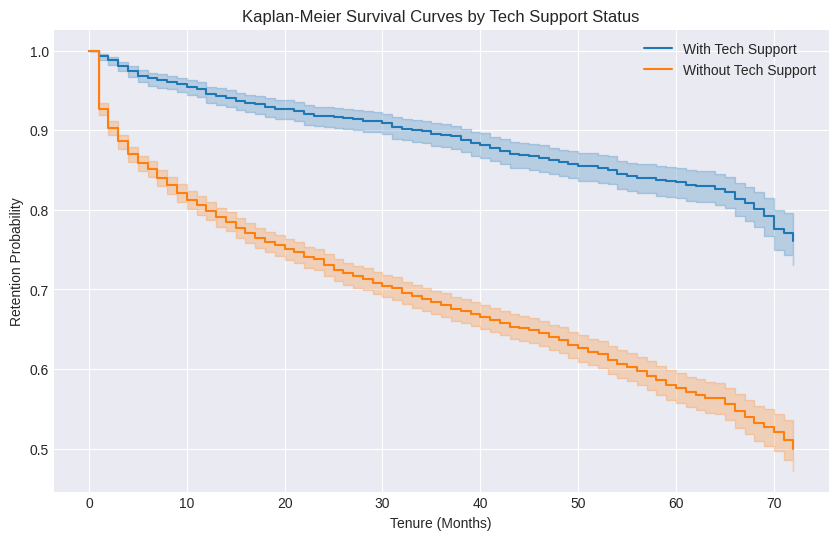

In [124]:
import matplotlib.pyplot as plt

tech_support_yes = df[df['TechSupport_Yes'] == 1]
tech_support_no = df[df['TechSupport_Yes'] == 0]

# Create Kaplan-Meier Fitter objects
kmf_yes = KaplanMeierFitter()
kmf_no = KaplanMeierFitter()

# Fit the models to the data
kmf_yes.fit(tech_support_yes['tenure'], event_observed=tech_support_yes['Churn'], label='With Tech Support')
kmf_no.fit(tech_support_no['tenure'], event_observed=tech_support_no['Churn'], label='Without Tech Support')

# Plot the survival curves
plt.figure(figsize=(10, 6))
kmf_yes.plot_survival_function()
kmf_no.plot_survival_function()

plt.title('Kaplan-Meier Survival Curves by Tech Support Status')
plt.xlabel('Tenure (Months)')
plt.ylabel('Retention Probability')
plt.legend()
plt.show()

The Kaplan-Meier analysis reveals that customers with tech support have significantly higher retention rates over time compared to those without. This indicates that tech support plays a critical role in reducing churn and enhancing customer lifetime value.



In [141]:

# **Task 4: Identify top 10% of customers by churn probability. Propose a retention campaign for them and justify it in 100 words using churn prediction results.**

# Identify the top 10% of customers by churn probability
top_10_percent_threshold = test_results1['Churn_Probability'].quantile(0.9)
top_churn_risk_customers = test_results1[test_results1['Churn_Probability'] >= top_10_percent_threshold]

print(f"\nThreshold for Top 10% Churn Probability: {top_10_percent_threshold:.4f}")
print(f"\nNumber of customers in Top 10% Churn Risk: {len(top_churn_risk_customers)}")

print("\nTop 10% Churn Risk Customers (Sample):")
print(top_churn_risk_customers.head())


Threshold for Top 10% Churn Probability: 0.6026

Number of customers in Top 10% Churn Risk: 141

Top 10% Churn Risk Customers (Sample):
        tenure  MonthlyCharges  TotalCharges  SeniorCitizen  gender_Male  \
1807 -1.277445        0.385148     -0.973713      -0.439916        False   
3801 -0.585198        0.687595     -0.342618       2.273159        False   
6179 -0.870241        1.009984     -0.566978       2.273159        False   
3469 -0.707359        0.888673     -0.389216       2.273159        False   
4343 -0.992402        0.365207     -0.739773       2.273159        False   

      Partner_Yes  Contract_One year  Contract_Two year  Churn_Probability  \
1807        False              False              False           0.606524   
3801        False              False              False           0.616625   
6179        False              False              False           0.722552   
3469        False              False              False           0.677989   
4343        Fals

Top 10% churn probability threshold is 0.6026: This means any customer with a churn probability above 0.6026 is considered to be in the top 10% highest churn risk group.

Target Group:
- Customers with:
- Month-to-month contracts
- Churn probability > 0.6026
- Low tenure
- Often senior citizens
- Moderate to high monthly charges
- Not currently partnered



In [142]:
# Proposed Retention Campaign

print("\n--- Proposed Retention Campaign for Top 10% Churn Risk Customers ---")

task4_interpretation = """
Based on the logistic regression model, we've identified the top 10% of customers with the highest predicted churn probability (above {top_10_percent_threshold:.4f}).
These customers represent the most critical segment for immediate retention efforts.
A proposed retention campaign could involve:
1. Proactive outreach: Contacting these customers personally via phone or email to understand their satisfaction levels and address any concerns.
2. Special offers: Providing exclusive discounts, personalized plan upgrades, or loyalty rewards to incentivize them to stay.
3. Improved support: Offering dedicated or prioritized customer support to quickly resolve issues and demonstrate commitment to their experience.
This targeted approach maximizes resources by focusing on customers most likely to churn, using the prediction results to prioritize intervention.
"""
print(task4_interpretation.format(top_10_percent_threshold=top_10_percent_threshold))


--- Proposed Retention Campaign for Top 10% Churn Risk Customers ---

Based on the logistic regression model, we've identified the top 10% of customers with the highest predicted churn probability (above 0.6026). 
These customers represent the most critical segment for immediate retention efforts. 
A proposed retention campaign could involve: 
1. Proactive outreach: Contacting these customers personally via phone or email to understand their satisfaction levels and address any concerns.
2. Special offers: Providing exclusive discounts, personalized plan upgrades, or loyalty rewards to incentivize them to stay.
3. Improved support: Offering dedicated or prioritized customer support to quickly resolve issues and demonstrate commitment to their experience.
This targeted approach maximizes resources by focusing on customers most likely to churn, using the prediction results to prioritize intervention.

